Libraries

In [ ]:
pip install deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.9/514.9 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import deeplake

Importing dataset

In [ ]:
ds_train = deeplake.load("hub://activeloop/lsp-train")
ds_test = deeplake.load("hub://activeloop/lsp-test")

dataloader_train = ds_train.tensorflow()
dataloader_test = ds_test.tensorflow()

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



\

hub://activeloop/lsp-train loaded successfully.



|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test



-

hub://activeloop/lsp-test loaded successfully.



Normalization and Denormalization Functions

In [ ]:
def normalization(keypoints, box):
    keypoints[:,0] = (keypoints[:,0] - box[0])/box[2]
    keypoints[:,1] = (keypoints[:,1] - box[1])/box[3]
    return keypoints

In [ ]:
def denormalization(keypoints,box):
    keypoints[:,0] = (keypoints[:,0]*box[2]) + box[0]
    keypoints[:,1] = (keypoints[:,1]*box[3]) + box[1]
    keypoints[:,0] = np.clip(keypoints[:,0],0,box[2])
    keypoints[:,1] = np.clip(keypoints[:,1],0,box[3])
    return keypoints.astype(np.int32)

Keypoints Visualization

In [ ]:
def visualize_keypoints(image,keypoints,image_visualized):
    height,width = image_visualized.shape[:2]
    try:
        image = cv2.resize(image.numpy(),(width,height))
    except:
        image = cv2.resize(image,(width,height))
    fig , ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image)
    ax.scatter(keypoints[:,0],keypoints[:,1])
    for i in range(keypoints.shape[0]):
        ax.annotate(str(i), (keypoints[i,0],keypoints[i,1]),fontsize=10)
    for i in range(0,5):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(6,11):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(12,13):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    plt.show()

Trying above function on sample

In [ ]:
batch_iter = iter(dataloader_train)
batch = next(batch_iter)

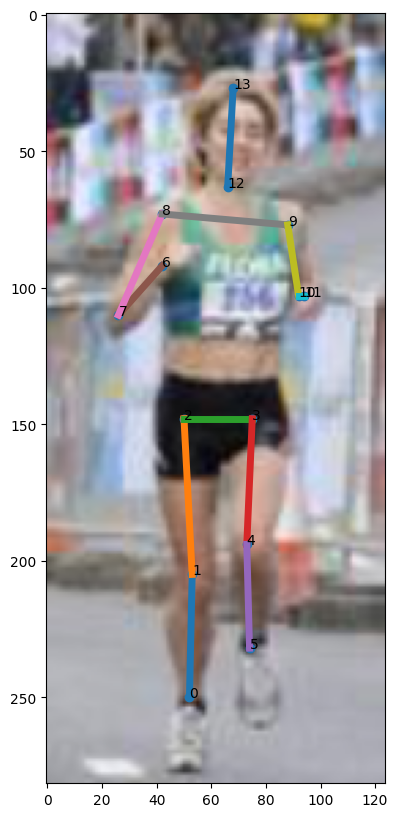

In [ ]:
image = batch["images"]
keypoints = batch["keypoints"]
image_visualized = batch["images_visualized"]

# Visualize the keypoints
visualize_keypoints(image,keypoints,image_visualized)

Preparing training set

In [ ]:
images = []
keypoints_array = []


for batch in dataloader_train:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalization(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)


for batch in dataloader_test:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalization(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)


images = np.array(images)
keypoints_array = np.array(keypoints_array,dtype=np.float32)

Model

In [ ]:
def get_model(output = 14*2):
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(96,(11,11),strides=(4,4),activation="relu",input_shape=(220,220,3)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2)),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(output,activation="linear")])
    return model

In [ ]:
model = get_model()

Loss Function

In [ ]:
def loss_fn(y_true,y_pred):
    y_pred = tf.reshape(y_pred,(-1,14,2))
    return tf.reduce_sum(tf.square(y_true-y_pred))

Model compilation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss_fn)

In [ ]:
model.fit(images,keypoints_array,epochs=10,batch_size=32,validation_split=0.1,shuffle=True,verbose=1)

Epoch 1/10
57/57 [==============================] - 274s 5s/step - loss: 709.2325 - val_loss: 33.7397
Epoch 2/10
57/57 [==============================] - 259s 5s/step - loss: 131.3118 - val_loss: 30.7715
Epoch 3/10
57/57 [==============================] - 259s 5s/step - loss: 75.9708 - val_loss: 29.3004
Epoch 4/10
57/57 [==============================] - 254s 4s/step - loss: 54.7905 - val_loss: 27.9016
Epoch 5/10
57/57 [==============================] - 261s 5s/step - loss: 42.4470 - val_loss: 26.9499
Epoch 6/10
57/57 [==============================] - 258s 5s/step - loss: 35.6684 - val_loss: 27.1881
Epoch 7/10
57/57 [==============================] - 260s 5s/step - loss: 30.9095 - val_loss: 27.1150
Epoch 8/10
57/57 [==============================] - 253s 4s/step - loss: 27.7018 - val_loss: 27.3267
Epoch 9/10
57/57 [==============================] - 251s 4s/step - loss: 25.5249 - val_loss: 26.4223
Epoch 10/10
57/57 [==============================] - 249s 4s/step - loss: 23.8179 - val_l

In [ ]:
model.save("deeppose.h5")

In [ ]:
model = tf.keras.models.load_model("deeppose.h5",custom_objects={"loss_fn":loss_fn})

Getting predictions from model

In [ ]:
def predict(model,image):
    image= cv2.resize(image,(220,220))
    image = np.expand_dims(image,axis=0)
    image = tf.convert_to_tensor(image,dtype=tf.float32)
    pred = model(image)
    pred = tf.reshape(pred,(14,2))
    return pred

In [ ]:
test_iter = iter(dataloader_test)

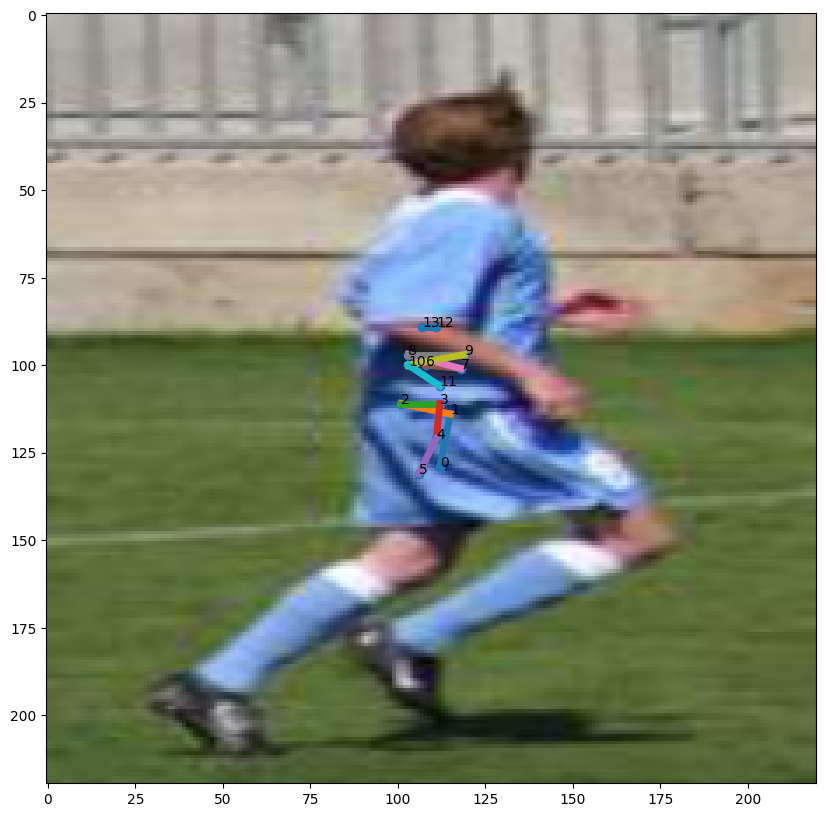

In [ ]:
img = next(test_iter)["images"].numpy()
img = cv2.resize(img,(220,220))
image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
pred = predict(model,image).numpy()
keypoints = denormalization(pred,(110,110,220,220))
visualize_keypoints(img,keypoints,img)

In [ ]:
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(220,220))
#image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
#pred = predict(model,image).numpy()
#keypoints = denormalization(pred,(110,110,220,220))
#visualize_keypoints(img,keypoints,img)

it predicts the above image well.

Cascade Model